In [ ]:
!pip install pandas
!pip install numpy
!pip install scipy
!pip install matplotlib
!pip install seaborn
!pip install statsmodels
!pip install scikit-learn
!pip install pycaret

In [37]:
import warnings
warnings.filterwarnings('ignore')
from IPython.display import clear_output

import pandas as pd
import numpy as np
import datetime
from scipy import interpolate
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline
from pylab import rcParams
import seaborn as sns
import statsmodels.api as sm
import math
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error
from pycaret.regression import *

plt.rc("font", family="Malgun Gothic")
plt.rcParams['axes.unicode_minus'] = False

## 데이터 불러오기

In [2]:
# 학습 데이터
data_tr = pd.read_csv('./t1_data_city/data_tr_city.csv')
data_tr

,datetime,구미 혁신도시배수지 유출유량 적산차
0,2017-01-01 01:00:00,138.0
1,2017-01-01 02:00:00,237.0
2,2017-01-01 03:00:00,128.0
3,2017-01-01 04:00:00,14.0
4,2017-01-01 05:00:00,11.0
...,...,...
35058,2020-12-31 19:00:00,328.0
35059,2020-12-31 20:00:00,347.0
35060,2020-12-31 21:00:00,335.0
35061,2020-12-31 22:00:00,141.0


In [3]:
# 평가 데이터
data_ts = pd.read_csv('./t1_data_city/data_ts_city.csv')
data_ts

,datetime,구미 혁신도시배수지 유출유량 적산차
0,2021-01-01 00:00:00,106.0
1,2021-01-01 01:00:00,184.0
2,2021-01-01 02:00:00,277.0
3,2021-01-01 03:00:00,197.0
4,2021-01-01 04:00:00,72.0
...,...,...
8419,2021-12-17 19:00:00,327.0
8420,2021-12-17 20:00:00,513.0
8421,2021-12-17 21:00:00,396.0
8422,2021-12-17 22:00:00,350.0


In [4]:
# 제출 양식
data_sample = pd.read_csv('./t1_data_city/sample_city.csv')
data_sample

,datetime,h0,h1,h2,h3,h4,h5,h6,h7,h8,...,h326,h327,h328,h329,h330,h331,h332,h333,h334,h335
0,2021-01-01 00:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2021-01-01 01:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2021-01-01 02:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2021-01-01 03:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2021-01-01 04:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8420,2021-12-17 20:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8421,2021-12-17 21:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8422,2021-12-17 22:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8423,2021-12-17 23:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 컬럼명 변경

In [5]:
data_tr.rename(columns= {'구미 혁신도시배수지 유출유량 적산차':'적산차'}, inplace=True)
data_ts.rename(columns= {'구미 혁신도시배수지 유출유량 적산차':'적산차'}, inplace=True)
data_tr.head()

,datetime,적산차
0,2017-01-01 01:00:00,138.0
1,2017-01-01 02:00:00,237.0
2,2017-01-01 03:00:00,128.0
3,2017-01-01 04:00:00,14.0
4,2017-01-01 05:00:00,11.0


### 결측치 확인

In [6]:
data_tr[data_tr.적산차.isnull()]

,datetime,적산차
1748,2017-03-14 21:00:00,NaN
1982,2017-03-24 15:00:00,NaN
12716,2018-06-14 21:00:00,NaN
12717,2018-06-14 22:00:00,NaN
13187,2018-07-04 12:00:00,NaN
13234,2018-07-06 11:00:00,NaN
27253,2020-02-10 14:00:00,NaN
27254,2020-02-10 15:00:00,NaN


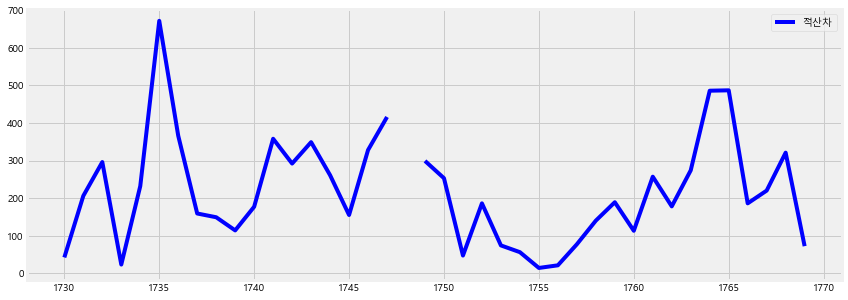

In [7]:
# 결측치 중 한 곳을 시각화
rcParams['figure.figsize'] = 13, 5
data_tr[1730:1770].plot(c='blue')
plt.show()

### 결측치 보간

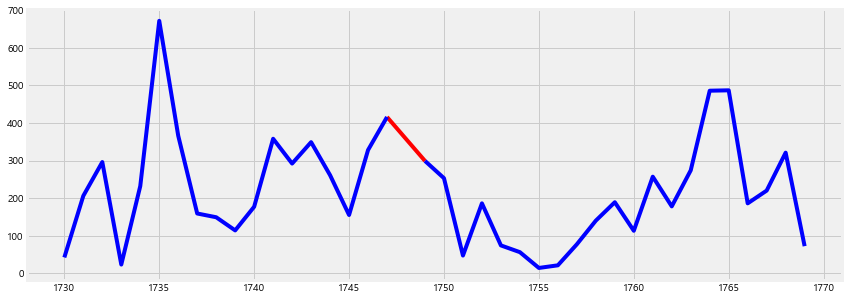

In [8]:
# linear 보간을 통해 결측치 처리
data_tr_interpolate = data_tr.interpolate(method = 'linear')

# 보간 후 데이터 시각화
data_tr_interpolate[1747:1750].적산차.plot(c='red')
data_tr[1730:1770].적산차.plot(c='blue')
plt.show()

data_tr = data_tr_interpolate

### 이상치 확인

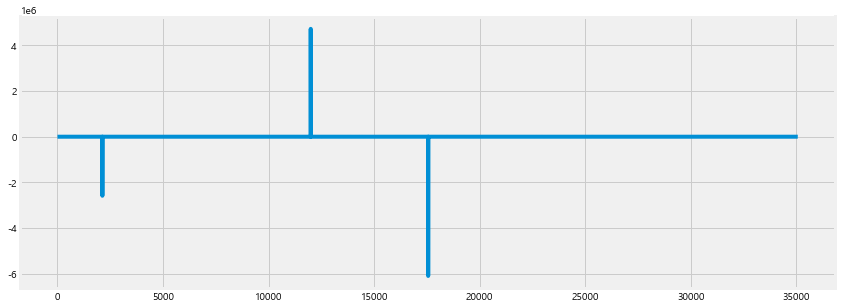

In [9]:
# 적산차가 비정상적으로 적거나 많게 표기된 행이 존재
rcParams['figure.figsize'] = 13, 5
data_tr.적산차.plot()
plt.show()

In [10]:
index = data_tr[data_tr.적산차 == max(data_tr.적산차)].index
print(index)
data_tr.적산차[index] = np.NaN

Int64Index([11995], dtype='int64')


In [11]:
index = data_tr[data_tr.적산차 == min(data_tr.적산차)].index
print(index)
data_tr.적산차[index] = np.NaN

Int64Index([17558], dtype='int64')


In [12]:
# 앞서 min(data_tr.적산차)인 행을 nan값으로 변경했으므로 그 다음 min값이 리턴된다.
index = data_tr[data_tr.적산차 == min(data_tr.적산차)].index
print(index)
data_tr.적산차[index] = np.NaN

Int64Index([2127], dtype='int64')


#### 이상치 제거 결과

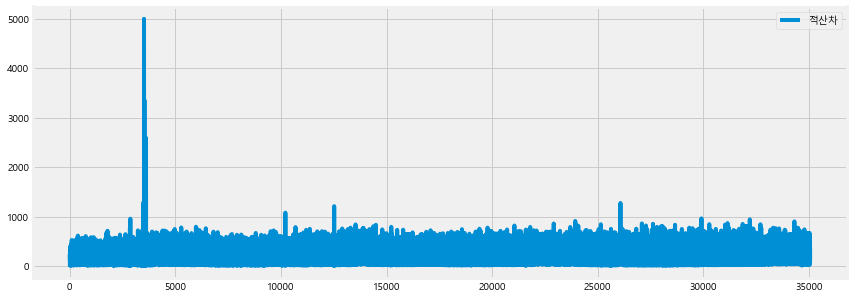

In [13]:
data_tr.plot()
plt.show()

In [14]:
# linear 보간을 통해 nan이 된 이상치를 처리
data_tr_interpolate = data_tr.interpolate(method = 'linear')
data_tr = data_tr_interpolate

In [15]:
# 시계열 분석을 위해 index를 datetime으로 변경
data_tr['datetime'] = pd.to_datetime(data_tr['datetime'])
data_tr.set_index('datetime', inplace=True)

data_ts['datetime'] = pd.to_datetime(data_ts['datetime'])
data_ts.set_index('datetime', inplace=True)

data_tr

,적산차
datetime,
2017-01-01 01:00:00,138.0
2017-01-01 02:00:00,237.0
2017-01-01 03:00:00,128.0
2017-01-01 04:00:00,14.0
2017-01-01 05:00:00,11.0
...,...
2020-12-31 19:00:00,328.0
2020-12-31 20:00:00,347.0
2020-12-31 21:00:00,335.0


### Pycaret

In [24]:
# 기존에 정의했던 데이터셋을 활용하기 쉽게 재설계해준다.

train = data_tr.copy()
train.rename(columns= {'적산차':'y'}, inplace=True)
train['datetime'] = train.index
train.reset_index(drop=True, inplace=True)

train

,y,datetime
0,138.0,2017-01-01 01:00:00
1,237.0,2017-01-01 02:00:00
2,128.0,2017-01-01 03:00:00
3,14.0,2017-01-01 04:00:00
4,11.0,2017-01-01 05:00:00
...,...,...
35058,328.0,2020-12-31 19:00:00
35059,347.0,2020-12-31 20:00:00
35060,335.0,2020-12-31 21:00:00
35061,141.0,2020-12-31 22:00:00


#### 파생변수를 생성

In [25]:
def make_derived_variable(df):

    df['weekday'] = [d.weekday() for d in df.datetime] # 월=0, 화=1 ...
    df['month'] = df.datetime.dt.month
    df['hour'] = df.datetime.dt.hour
    df['year'] = df.datetime.dt.year
    
    return df

'''
def make_previous_y(df, p):
    
    for i in range(1, p+1):
        df['previous_y'+str(i)] = [np.NaN]*(i) + list(df.y[:-(i)])
    
    #df['previous_y'+str(i)] = [np.NaN] + list(df.y[:-1]) # 바로 직전 시간의 y를 변수로 생성
    
    return df
'''
def make_previous_y(df):
    
    df['previous_y'] = [np.NaN] + list(df.y[:-1]) # 바로 직전 시간의 y를 변수로 생성
    
    return df

#### train set

In [26]:
train = make_derived_variable(train)
train = make_previous_y(train)
train

,y,datetime,weekday,month,hour,year,previous_y
0,138.0,2017-01-01 01:00:00,6,1,1,2017,NaN
1,237.0,2017-01-01 02:00:00,6,1,2,2017,138.0
2,128.0,2017-01-01 03:00:00,6,1,3,2017,237.0
3,14.0,2017-01-01 04:00:00,6,1,4,2017,128.0
4,11.0,2017-01-01 05:00:00,6,1,5,2017,14.0
...,...,...,...,...,...,...,...
35058,328.0,2020-12-31 19:00:00,3,12,19,2020,305.0
35059,347.0,2020-12-31 20:00:00,3,12,20,2020,328.0
35060,335.0,2020-12-31 21:00:00,3,12,21,2020,347.0
35061,141.0,2020-12-31 22:00:00,3,12,22,2020,335.0


In [27]:
# previous_y[0] = NaN 인데, 이는 이전 시간의 데이터가 없기 떄문.
# train 데이터는 이전 데이터를 지니지 않았으므로 0번째 행은 제거하고 학습을 하도록 한다.
#train = train[p:].reset_index(drop=True)
#train.head()

#### 파생변수로 차분 추가

In [28]:
# 예측 시에는 자기자신의 실제 값을 모른다. 따라서 차분한 결과를 한 행씩 뒤에 배치한다.
def make_difference(df, d):
    
    for i in range(1, d+1):
        df['diff'+str(i)] = [np.NaN]*(i+1) + list(df.y.diff(i)[i:-1])

    return df

In [29]:
# train 이전의 데이터는 존재하지 않으므로, 차분 결과의 공란을 채울 방법이 없다. -> 채울 수 없는 데이터는 제거한다.
d = 5
train = make_difference(train, d)
train

,y,datetime,weekday,month,hour,year,previous_y,diff1,diff2,diff3,diff4,diff5
0,138.0,2017-01-01 01:00:00,6,1,1,2017,NaN,NaN,NaN,NaN,NaN,NaN
1,237.0,2017-01-01 02:00:00,6,1,2,2017,138.0,NaN,NaN,NaN,NaN,NaN
2,128.0,2017-01-01 03:00:00,6,1,3,2017,237.0,99.0,NaN,NaN,NaN,NaN
3,14.0,2017-01-01 04:00:00,6,1,4,2017,128.0,-109.0,-10.0,NaN,NaN,NaN
4,11.0,2017-01-01 05:00:00,6,1,5,2017,14.0,-114.0,-223.0,-124.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
35058,328.0,2020-12-31 19:00:00,3,12,19,2020,305.0,-168.0,51.0,101.0,-30.0,-42.0
35059,347.0,2020-12-31 20:00:00,3,12,20,2020,328.0,23.0,-145.0,74.0,124.0,-7.0
35060,335.0,2020-12-31 21:00:00,3,12,21,2020,347.0,19.0,42.0,-126.0,93.0,143.0
35061,141.0,2020-12-31 22:00:00,3,12,22,2020,335.0,-12.0,7.0,30.0,-138.0,81.0


In [30]:
train = train[d+1:]
train

,y,datetime,weekday,month,hour,year,previous_y,diff1,diff2,diff3,diff4,diff5
6,11.0,2017-01-01 07:00:00,6,1,7,2017,10.0,-1.0,-4.0,-118.0,-227.0,-128.0
7,187.0,2017-01-01 08:00:00,6,1,8,2017,11.0,1.0,0.0,-3.0,-117.0,-226.0
8,392.0,2017-01-01 09:00:00,6,1,9,2017,187.0,176.0,177.0,176.0,173.0,59.0
9,114.0,2017-01-01 10:00:00,6,1,10,2017,392.0,205.0,381.0,382.0,381.0,378.0
10,243.0,2017-01-01 11:00:00,6,1,11,2017,114.0,-278.0,-73.0,103.0,104.0,103.0
...,...,...,...,...,...,...,...,...,...,...,...,...
35058,328.0,2020-12-31 19:00:00,3,12,19,2020,305.0,-168.0,51.0,101.0,-30.0,-42.0
35059,347.0,2020-12-31 20:00:00,3,12,20,2020,328.0,23.0,-145.0,74.0,124.0,-7.0
35060,335.0,2020-12-31 21:00:00,3,12,21,2020,347.0,19.0,42.0,-126.0,93.0,143.0
35061,141.0,2020-12-31 22:00:00,3,12,22,2020,335.0,-12.0,7.0,30.0,-138.0,81.0


#### test set

In [31]:
test = data_ts.copy()
test.rename(columns= {'적산차':'y'}, inplace=True)
test['datetime'] = test.index
test.reset_index(drop=True, inplace=True)

test

,y,datetime
0,106.0,2021-01-01 00:00:00
1,184.0,2021-01-01 01:00:00
2,277.0,2021-01-01 02:00:00
3,197.0,2021-01-01 03:00:00
4,72.0,2021-01-01 04:00:00
...,...,...
8419,327.0,2021-12-17 19:00:00
8420,513.0,2021-12-17 20:00:00
8421,396.0,2021-12-17 21:00:00
8422,350.0,2021-12-17 22:00:00


In [32]:
# test set은 train set을 활용해서 nan을 채울 수 있다.
test = pd.concat([train[-(d+1):], test])
test = make_derived_variable(test)
test = make_previous_y(test)
test = make_difference(test, d)
test.head(7)

,y,datetime,weekday,month,hour,year,previous_y,diff1,diff2,diff3,diff4,diff5
35057,305.0,2020-12-31 18:00:00,3,12,18,2020,NaN,NaN,NaN,NaN,NaN,NaN
35058,328.0,2020-12-31 19:00:00,3,12,19,2020,305.0,NaN,NaN,NaN,NaN,NaN
35059,347.0,2020-12-31 20:00:00,3,12,20,2020,328.0,23.0,NaN,NaN,NaN,NaN
35060,335.0,2020-12-31 21:00:00,3,12,21,2020,347.0,19.0,42.0,NaN,NaN,NaN
35061,141.0,2020-12-31 22:00:00,3,12,22,2020,335.0,-12.0,7.0,30.0,NaN,NaN
35062,112.0,2020-12-31 23:00:00,3,12,23,2020,141.0,-194.0,-206.0,-187.0,-164.0,NaN
0,106.0,2021-01-01 00:00:00,4,1,0,2021,112.0,-29.0,-223.0,-235.0,-216.0,-193.0


### Pycaret
* 최적의 모델 탐색 및 간단한 튜닝과 학습을 진행해주는 AutoML
* pycaret은 python 3.6 이하에서 사용이 가능합니다. 현재 환경에 따라 넘겨주세요.

In [55]:
sup = setup(train, target = 'y', train_size = 0.7, n_jobs=4)

,Description,Value
0,session_id,4303
1,Target,y
2,Original Data,"(35057, 12)"
3,Missing Values,False
4,Numeric Features,7
5,Categorical Features,3
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(24539, 56)"


In [81]:
model = compare_models(sort = 'MAE', fold=5, n_select=1) # 최상위 모델 하나만 선택한다.

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,85.6424,14712.3442,120.7838,0.4797,0.6782,0.6301,0.1800
gbr,Gradient Boosting Regressor,86.9056,14915.8775,121.6008,0.4726,0.6905,0.6536,2.3280
et,Extra Trees Regressor,87.0654,15735.3529,124.8631,0.4433,0.6764,0.6415,2.1480
lr,Linear Regression,87.7670,15191.9000,122.7009,0.4629,0.7091,0.6607,0.4980
ridge,Ridge Regression,87.7710,15192.4047,122.7027,0.4629,0.7087,0.6613,0.0520
br,Bayesian Ridge,87.7870,15193.2814,122.7066,0.4629,0.7071,0.6640,0.0840
rf,Random Forest Regressor,88.0966,15916.0314,125.6586,0.4367,0.6839,0.6635,3.1280
xgboost,Extreme Gradient Boosting,88.2342,16448.5951,127.8281,0.4166,0.6878,0.6229,0.7560
lasso,Lasso Regression,90.6477,15814.5059,125.2243,0.4405,0.7302,0.7653,0.2060
huber,Huber Regressor,91.9141,16554.2580,128.1376,0.4139,0.7373,0.7546,0.7620


In [82]:
tuned_model = tune_model(model, fold=5, optimize='MAE')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,86.6877,20681.7573,143.8115,0.3941,0.6788,0.6175
1,87.0345,14254.7554,119.3933,0.4762,0.6938,0.6167
2,84.6699,13253.1957,115.1225,0.4973,0.6505,0.6006
3,89.5065,14610.6951,120.8747,0.4540,0.7062,0.6214
4,85.5244,12767.2809,112.9924,0.5045,0.6765,0.6832
Mean,86.6846,15113.5369,122.4389,0.4652,0.6812,0.6279
Std,1.6426,2862.2097,11.0569,0.0397,0.0187,0.0286


In [38]:
# 하나씩 예측할 경우
def predict_one_step(d, n, test): # d=diff, n=len(sample), test=test
    for i in tqdm(range(n)):
        start = test['datetime'][i]
        date_range = pd.date_range(start, start + datetime.timedelta(hours=335), freq='H')
        temp = pd.DataFrame({'datetime':date_range, 'y':np.NaN})
        temp = pd.concat([test[['datetime', 'y']].iloc[i:i+d+1], temp])
        temp = make_derived_variable(temp)

        for j in range(336):
            temp = make_previous_y(temp)
            temp = make_difference(temp, d)
            forecast = predict_model(tuned_model, temp[d+1+j:d+2+j])['Label'].iloc[0]
            temp['y'].iloc[d+1+j] = forecast

        data_sample.loc[i] = [start] + list(temp[d+1:]['y'])
        clear_output()

    return(data_sample)

In [39]:
#data_sample = predict_one_step(7, len(data_sample), test)

In [87]:
# 빠르게 여러 일자를 한 step씩 예측하는 경우
d = p = 7

train = data_tr.copy()
train.rename(columns= {'적산차':'y'}, inplace=True)
train['datetime'] = train.index
train.reset_index(drop=True, inplace=True)

test = data_ts.copy()
test.rename(columns= {'적산차':'y'}, inplace=True)
test['datetime'] = test.index
test.reset_index(drop=True, inplace=True)

df = pd.concat([train.copy()[-(d+1):], test.copy()], ignore_index=True)

start = pd.to_datetime(data_sample.datetime[8424])
date_range = pd.date_range(start, start + datetime.timedelta(hours=335), freq='H')
temp = pd.DataFrame({'datetime':date_range, 'y':np.NaN})
df = pd.concat([df, temp], ignore_index=True)

df = make_derived_variable(df)
df = make_previous_y(df, p)
df = make_difference(df, d)

for i in tqdm(range(336)):
    pred = predict_model(tuned_model, data=df[d+1+i:])
    
    df['yhat'+str(i+1)] = np.NaN
    df.loc[np.arange(d+1+i, d+8426+i), 'yhat'+str(i+1)] = pred['Label']
    
    df.loc[np.arange(d+1+i, d+8426+i), 'y'] = pred['Label']
    
    df = make_derived_variable(df)
    df = make_previous_y(df, p)
    df = make_difference(df, d)
    
    clear_output()
    
for i in tqdm(range(len(data_sample))):
    data_sample.loc[i] = [pd.to_datetime(data_sample.datetime[i])] + [df['yhat'+str(j+1)][d+1+i+j] for j in range(336)]

100%|██████████| 8425/8425 [05:48<00:00, 24.16it/s]


In [88]:
#대략적인 성능 평가
mae_list = []
for i in tqdm(range(8000)):
    result = []
    for j in range(336):
        result.append(df['yhat'+str(j+1)][d+1+i+j])
    mae_list.append(mean_absolute_error(data_ts['적산차'][i:i+336], result))
mae = np.mean(mae_list)
mae        

100%|██████████| 8000/8000 [00:15<00:00, 516.36it/s]


92.30734901612514

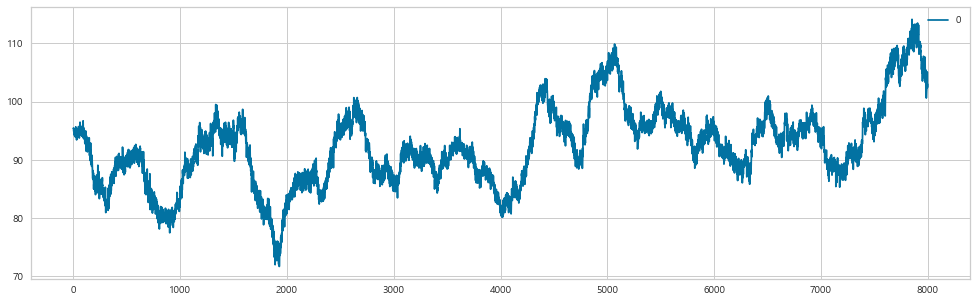

In [89]:
# 각 일자별 336step의 mae 평균
pd.DataFrame(mae_list).plot()
plt.show()

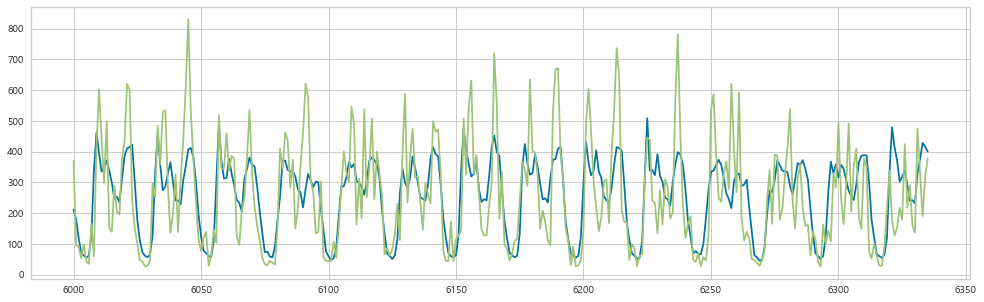

In [90]:
# 예측한 결과 = 파란색. 시간별 적산차 분포
i = 6000
result = []
for j in range(336):
    result.append(df['yhat'+str(j+1)][d+1+i+j])
ttt = pd.DataFrame({'a':result, 'b':test[i:i+336].y})
ttt.a.plot()
ttt.b.plot()
plt.show()

In [93]:
model

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=4, num_leaves=31, objective=None,
              random_state=5898, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

* pycaret은 lgbm을 최적의 모델로 선택했고 그 결과는 prophet과 큰 차이가 나지 않음.
* optuna를 이용해 하이퍼파라미터 탐색을 진행